In [216]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform
import math
import random
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d

In [217]:
def non_maximal_suppresion(args,nice_resp,sort_idx,y,x):
    rad = [0]*len(sort_idx)
    rad[sort_idx[0]]=np.inf
    for i,idx in enumerate(sort_idx):
        if(i==0):
            continue
        valid = sort_idx[:i][nice_resp[idx]<args["c_robust"]*nice_resp[sort_idx[:i]]]
        # print(f"valid:{valid}")
        if(len(valid)==0):
            print("non_maximal screw up")
        d_x = x[valid]-x[idx]
        d_y = y[valid]-y[idx]
        rad[idx] = (np.sqrt(np.min(d_x**2+d_y**2)))

    return rad

In [218]:
def get_corner_resp(S_xx,S_xy,S_yy,k=0.04):
    det = S_xx * S_yy - S_xy *S_xy
    trace = S_xx + S_yy
    response = det - k * (trace ** 2)
    return response

In [219]:
def local_max(corner_resp,threshold):
    ks = []
    for y in range(3):
        for x in range(3):
            if x == 1 and y == 1: continue
            k = np.zeros((3, 3), dtype=np.float64)
            k[1, 1] = 1
            k[y, x] = -1
            ks.append(k)

    localMax = np.ones(corner_resp.shape, dtype=np.uint8)
    localMax[corner_resp <= threshold] = 0

    for k in ks:
        d = np.sign(cv2.filter2D(corner_resp, -1, k))
        d[d < 0] = 0
        localMax &= np.uint8(d)

    print('founded corners:', np.sum(localMax))
    Y,X = np.nonzero(localMax > 0)

    return Y,X

In [220]:
def get_feats_disp(img,x,y,window):
    print(f"detecting features discriptor")
    img = np.pad(img,window//2,"symmetric")
    total_feats = np.empty((len(x),256))
    for idx ,(i,j) in enumerate(zip(x,y)):
        crop = cv2.resize(img[j:j+window,i:i+window],(16,16),interpolation=cv2.INTER_CUBIC).flatten()
        crop = (crop-np.mean(crop))/np.std(crop)
        total_feats[idx] = crop
    return total_feats


In [221]:
def harris_detection(args,img_path):
    print(img_path)
    rgb1 = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB).astype(np.float64)/255
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    
    print("Image size:",img.shape)
    if(args["sobel"]==False):
        blur_img = cv2.GaussianBlur(img,(args["window_size"],args["window_size"]),args["sigma"])
        # blur_img = img
        dy, dx = np.gradient(blur_img)
    else:
        blur_img = cv2.GaussianBlur(img,(args["window_size"],args["window_size"]),args["sigma"])
        # blur_img = img
        sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]
                ])
        sobel_y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]
                ])
        dy = convolve2d(blur_img,sobel_y,boundary='symm',mode = 'same')
        dx = convolve2d(blur_img,sobel_x,boundary='symm',mode = 'same')

    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2

    truncate = (((args["window_size"]-1)//2)-0.5)/args["sigma"]
    k = 0.04
    S_xx = gaussian_filter(Ixx, sigma = args["sigma"], truncate = truncate)
    S_xy = gaussian_filter(Ixy, sigma = args["sigma"], truncate = truncate)
    S_yy = gaussian_filter(Iyy, sigma = args["sigma"], truncate = truncate)


    corner_resp = get_corner_resp(S_xx = S_xx,S_xy = S_xy,S_yy = S_yy,k=k)

    # print(f"max:{np.max(corner_resp)}")
    # print(f"min:{np.min(corner_resp)}")
    
    threshold = corner_resp.max()*args["threshold_ratio"]
    if(args["threshold_clip"]==True):
        threshold = args["threshold_bound"]

    print("threshold =",threshold)

    if(args["local_max"]==False):
        y,x = np.nonzero(corner_resp >= threshold)
        # assert y == np.where(corner_resp>=threshold)[0]
    else:
        y,x =local_max(corner_resp,threshold = threshold)
    # print(f"y:{y}")
    # print(f"len(y):{len(y)}")
    # exit()

    nice_resp = corner_resp[y,x]
    # valid_resp = {}
    # for i in range(len(y)):
    #     valid_resp[(y[i],x[i])] = corner_resp[y[i],x[i]]
    # sort_resp = sorted(list(valid_resp),key = lambda x:x[1],reverse = True)
    sort_idx = (-nice_resp).argsort()
    # print("valid_response:",sort_resp)
    print("len(nice_resp):",len(nice_resp))
    print(f"len(sort_idx):{len(sort_idx)}")
    
    if(args["non_maximal"]):
        print("start suppresion")
        rad = non_maximal_suppresion(args,nice_resp,sort_idx,y,x)
        rad = np.array(rad,dtype = np.float64)
        # print(f"rad:{rad}")
        final_idx = (-rad).argsort()[:args["num_features"]]
        # print(f"final_idx:{final_idx}")
        y = y[final_idx]
        x = x[final_idx]
    else:
        final_resp = sort_resp[:args["num_features"]]
        assert(len(final_resp)==y)
        for i in range(len(final_resp)):
            x[i] = final_resp[i][0][0]
            y[i] = final_resp[i][0][1]
    # print(f"len(y)and x:{len(y)}")
    ##--------------------------------------##
    if(args["print"]==True):
        rgb_fps = np.copy(rgb1)
        for j, i in zip(y, x):
            cv2.circle(rgb_fps, (i, j), radius=40, color=[255, 0, 0], thickness=10, lineType=1)

        rgb_arrows = np.copy(rgb1)      
        for j, i in zip(y, x):
            ex = int(i + dx[j, i] * 3),
            ey =  int(j + dy[j, i] * 3)
            ex, ey = np.clip(ex, 0, img.shape[1]), np.clip(ey, 0, img.shape[0])
            cv2.arrowedLine(rgb_arrows, (i, j), (ex, ey), (255, 255, 0), 5)

        fig, ax = plt.subplots(1, 3, figsize=(15, 6))
        fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, bottom=0.05, top=0.95)
        ax[0].imshow(rgb1); ax[ 0].set_title('Original')
        ax[ 1].imshow(corner_resp,cmap = "gray"); ax[ 1].set_title('Corner Response')
        ax[ 2].imshow(rgb_fps); ax[2].set_title('Feature Points')
        plt.show()
    ##-------------------------------------##
    # print(f"img:{img}")
    # print(f"x:{x}")
    # print(f"y:{y}")
    feats = get_feats_disp(img,x,y,args["window"])
    # print(f"feats:{feats}")
    return x,y,feats


In [222]:
def harris_detection_test(args,img_path):
    print(img_path)
    rgb1 = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB).astype(np.float64)/255
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    
    print("Image size:",img.shape)
    if(args["sobel"]==False):
        blur_img = cv2.GaussianBlur(img,(args["window_size"],args["window_size"]),args["sigma"])
        # blur_img = img
        dy, dx = np.gradient(blur_img)
    else:
        blur_img = cv2.GaussianBlur(img,(args["window_size"],args["window_size"]),args["sigma"])
        # blur_img = img
        sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]
                ])
        sobel_y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]
                ])
        dy = convolve2d(blur_img,sobel_y,boundary='symm',mode = 'same')
        dx = convolve2d(blur_img,sobel_x,boundary='symm',mode = 'same')

    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2

    truncate = (((args["window_size"]-1)//2)-0.5)/args["sigma"]
    k = 0.04
    S_xx = gaussian_filter(Ixx, sigma = args["sigma"], truncate = truncate)
    S_xy = gaussian_filter(Ixy, sigma = args["sigma"], truncate = truncate)
    S_yy = gaussian_filter(Iyy, sigma = args["sigma"], truncate = truncate)


    corner_resp = get_corner_resp(S_xx = S_xx,S_xy = S_xy,S_yy = S_yy,k=k)

    # print(f"max:{np.max(corner_resp)}")
    # print(f"min:{np.min(corner_resp)}")
    
    threshold = corner_resp.max()*args["threshold_ratio"]
    if(args["threshold_clip"]==True):
        threshold = args["threshold_bound"]

    print("threshold =",threshold)

    if(args["local_max"]==False):
        y,x = np.nonzero(corner_resp >= threshold)
        # assert y == np.where(corner_resp>=threshold)[0]
    else:
        y,x =local_max(corner_resp,threshold = threshold)
    # print(f"y:{y}")
    # print(f"len(y):{len(y)}")
    # exit()

    nice_resp = corner_resp[y,x]
    # valid_resp = {}
    # for i in range(len(y)):
    #     valid_resp[(y[i],x[i])] = corner_resp[y[i],x[i]]
    # sort_resp = sorted(list(valid_resp),key = lambda x:x[1],reverse = True)
    sort_idx = (-nice_resp).argsort()
    # print("valid_response:",sort_resp)
    print("len(nice_resp):",len(nice_resp))
    print(f"len(sort_idx):{len(sort_idx)}")
    
    if(args["non_maximal"]):
        print("start suppresion")
        rad = non_maximal_suppresion(args,nice_resp,sort_idx,y,x)
        rad = np.array(rad,dtype = np.float64)
        # print(f"rad:{rad}")
        final_idx = (-rad).argsort()[:args["num_features"]]
        # print(f"final_idx:{final_idx}")
        y = y[final_idx]
        x = x[final_idx]
    else:
        final_resp = sort_idx[:args["num_features"]]
        y = y[final_resp]
        x = x[final_resp]
    # print(f"len(y)and x:{len(y)}")
    ##--------------------------------------##
    rgb_fps = np.copy(rgb1)
    for j, i in zip(y, x):
        cv2.circle(rgb_fps, (i, j), radius=40, color=[255, 0, 0], thickness=10, lineType=1)


    if(ct ==0):
        title = 'sobel filter'
    elif(ct==1):
        title = "gradient"
    elif(ct==2):
        title = "no Local maximum and non-maximal suppression"
    elif(ct==3):
        title = "no Local maximum"
    elif(ct ==4):
        title = "no non-maximal suppression"
    ax[ ct].imshow(rgb_fps); ax[ct].set_title(title)
    # ax[1, 1].imshow(rgb_arrows); ax[1, 1].set_title('Gradients')
    # plt.show()
    ##-------------------------------------##
    # print(f"img:{img}")
    # print(f"x:{x}")
    # print(f"y:{y}")
    # feats = get_feats_disp(img,x,y,args["window"])
    # print(f"feats:{feats}")
    # return x,y,feats


In [223]:
def detect_features(args):
    print(args)
    if (args['bonus']==True):
        input_dir = args["bonus_input_dirpath"]
    else:
        input_dir = args["input_dirpath"]
    
    img_paths = sorted(os.listdir(input_dir),key = lambda x:int(x.split(".")[0]))
    x_coors = []
    y_coors = []
    total_feats = []
    for i,img_path in enumerate(img_paths):
        print(input_dir+"/"+img_path)
        x, y ,feats = harris_detection(args,input_dir+"/"+img_path)

        x_coors.append(x)
        y_coors.append(y)
        total_feats.append(feats)
        # break
    return x_coors,y_coors,total_feats

In [224]:
def translate(img, x, y):
    def param(var):
        x_v = var[:,0]
        y_v = var[:,1]
        x_v = x_v - x
        y_v = y_v - y
        xy = np.column_stack((x_v, y_v))
        return xy
    return (255*transform.warp(img, param, order=3, mode='constant', output_shape=(math.ceil(img.shape[0]+abs(y)), math.ceil(img.shape[1]+abs(x))))).astype(np.uint8)


def crop(imgs, f):
    x,y= imgs[0].shape[1]//2, imgs[0].shape[0]//2
    
    x2 = math.ceil(f*np.arctan(x/f))
    y2 = math.ceil(f*y/math.sqrt(x**2+f**2)) 

    x_diff = x - x2
    y_diff = y - y2

    output = []
    for img in imgs:
        output.append(img[y_diff-1190:-y_diff+250, x_diff:-x_diff+170])
    return output

In [225]:
def ransac(points, iteration=1000, thresh=3):
    num = len(points)
    best_score = -1
    for i in range(iteration):
        px_sum = 0
        py_sum = 0
        i1 = random.randint(0,num-1)
        
        p1 = points[i1][0]
        p2 = points[i1][1]
        p_diff = []
        for j in range(len(p2)):
            p_diff.append(p1[j]-p2[j])

        score = 0
        for p in points:
            t1 = p[0]
            t2 = p[1]
            t_diff = []
            for j in range(len(t2)):
                t_diff.append(t1[j]-t2[j])
            t_diff = np.array(t_diff)
            p_diff = np.array(p_diff)
            dis = np.linalg.norm(p_diff-t_diff)
            if (dis<thresh):
                score += 1
                px_sum += t_diff[0]
                py_sum += t_diff[1]
        if (score>best_score):
            best_score = score
            finalx = px_sum/score
            finaly = py_sum/score

    return finalx, finaly

def best_match(feat1, feat2, thresh):
    bestmatch = np.zeros((feat1.shape[0],2),dtype = np.int)
    tmp = []

    for i, f in enumerate(feat1):
        bestmatch[i] = np.argsort(np.sum(np.abs(feat2-f), axis=1).flatten())[:2]
        
    for i, f in enumerate(feat2):
        index = np.argsort(np.sum(np.abs(feat1-f), axis=1).flatten())
        if (bestmatch[index[0]][0]==i):
            tmp.append(index[0])
    
    p1,p2 = bestmatch[tmp][:,0],bestmatch[tmp][:,1]
    
    d1 = np.sum(np.abs(feat1[tmp]-feat2[p1]), axis=1)
    d2 = np.sum(np.abs(feat1[tmp]-feat2[p2]), axis=1)
    
    p = np.array(tmp, dtype=np.int)
    final_match = p[np.where(d1/d2 < thresh)[0]]

    return final_match, bestmatch[final_match][:, 0]

def match_pairs(x1, y1, x2, y2, feat1, feat2, thresh=0.5):
    p1,p2 = best_match(feat1, feat2, thresh)
    pi = list(zip(x1[p1], y1[p1]))
    pj = list(zip(x2[p2], y2[p2]))
    return list(zip(pi, pj))


In [226]:
#<--------------bonus----------------->

def find_firstimg(x,y,feat,w):
    index = []
    maxpair = []
    for i in range(len(feat)):
        index.append(i)
    for i in index:
        max_pair = 0
        for j in range(len(feat)):
            pair_num = 0
            # max_pair = 0
            if (i != j):
                pair = match_pairs(x[i], y[i], x[j], y[j], feat[i], feat[j], thresh=0.4)
                for p in pair:
                    if (p[1][0] > w/2):
                        pair_num += 1
                
                if (pair_num>=max_pair):
                    max_pair = pair_num
        print(f"{i}  max_pair:{max_pair}")
        maxpair.append(max_pair)
    first_index = maxpair.index(min(maxpair))
    print(f"first_index: {first_index}")
    return first_index


def bonus_align(img_path): 
    x,y,feat = detect_features(config) 
    shift = []
    imgs = set()
    for file in os.listdir(config["bonus_input_dirpath"]):
        img_path = config["bonus_input_dirpath"]+'/'+file
        break
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h,w = img.shape[0],img.shape[1]

    target = find_firstimg(x,y,feat,w)
    order = [target]
    for i in range(len(feat)):
        if (i != target):
            imgs.add(i)
    for i in range(len(feat)-1):
        max_pair = 0
        best_index = target
        best_pair = match_pairs(x[0], y[0], x[1], y[1], feat[0], feat[1], thresh=0.4)
        for j in imgs:
            pair_num = 0
            pair = match_pairs(x[target], y[target], x[j], y[j], feat[target], feat[j], thresh=0.35)
            print(f"{target} {j}  len(pair):{len(pair)}")
            for p in pair:
                if (p[1][0] < w/2):
                    pair_num += 1
            print(f"{target} {j}  pair_num:{pair_num}")
            if (pair_num>max_pair and pair_num>5):
                max_pair = pair_num
                best_index = j
                best_pair = pair
        if (best_index != target):
            print("--------------------------")
            print(f"best_index: {best_index}")
            order.append(best_index)
            target = best_index
            imgs.remove(best_index)
            proj_pair = []
            for p in best_pair:
                x1,y1 = convert_pt2(p[0][0], p[0][1], w, h)
                x2,y2 = convert_pt2(p[1][0], p[1][1], w, h)
                proj_pair.append([[x1,y1],[x2,y2]])
            dx, dy = ransac(proj_pair, 100, 3)
            shift.append([dx,dy])
            print(f"order: {order}")
    return shift, order

In [227]:
def align(img_path):
    x,y,feat = detect_features(config) 
   
    shift = []

    for file in os.listdir(config["input_dirpath"]):
        img_path = config["input_dirpath"]+'/'+file
        break
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h,w = img.shape[0],img.shape[1]
    for i in range(len(feat)-1):
        pair = match_pairs(x[i], y[i], x[i+1], y[i+1], feat[i], feat[i+1], thresh=0.5)
        print(f"len(pair):{len(pair)}")
        proj_pair = []
        for p in pair:
            x1,y1 = convert_pt2(p[0][0], p[0][1], w, h)
            x2,y2 = convert_pt2(p[1][0], p[1][1], w, h)
            proj_pair.append([[x1,y1],[x2,y2]])
        dx, dy = ransac(proj_pair, 100, 3)
        shift.append([dx,dy])
    return shift

In [228]:
def convert_pt2(x, y, w, h):
    center_x = x-w/2
    center_y = y-h/2

    f = -w/2
    omega = w/2
    z0 = f-math.sqrt(w*w-omega*omega)
    zc = (2*z0+math.sqrt(4*z0*z0-4*(center_x*center_x/(f*f)+1)*(z0*z0-w*w)))/(2* (center_x*center_x/(f*f)+1))

    final_x = (center_x)*f/zc + w/2
    final_y = (center_y)*f/zc + h/2

    return [final_x, final_y]

def convert_pt(x, y, w, h):
    center_x = x-w/2
    center_y = y-h/2

    f = -w/2
    omega = w/2
    z0 = f-math.sqrt(w*w-omega*omega)
    zc = (2*z0+math.sqrt(4*z0*z0-4*(center_x*center_x/(f*f)+1)*(z0*z0-w*w)))/(2* (center_x*center_x/(f*f)+1))

    final_x = center_x*zc/f + w/2
    final_y = center_y*zc/f + h/2

    return [final_x, final_y]

def CylindricalWarpImage():
    warped_imgs = []
    if (config['bonus']==True):
        save_path = config["bonus_warp_dirpath"]
        img_path = config["bonus_input_dirpath"]
        path = config["bonus_result_path"]
    else:
        save_path = config["warp_dirpath"]
        img_path = config["input_dirpath"]
        path = config["result_path"]
    os.makedirs(save_path,exist_ok = True)
    if (config["use_warp_cache"]==True):
        saves_path = sorted(os.listdir(save_path),key = lambda x:int(x.split(".")[0]))
        for index,img_name in enumerate((saves_path)): 
            print(f'cylind: {index}')
            img =  np.load(save_path+img_name) 
            cv2.imwrite(path+"warp"+str(index)+'.jpg', img)
            warped_imgs.append(img)
    else:
        imgs_path = sorted(os.listdir(img_path),key = lambda x:int(x.split(".")[0]))
        for index,img_name in enumerate(imgs_path):
            print(imgs_path)
            img = cv2.imread(img_path+img_name) 
            img = cv2.copyMakeBorder(img,1200,1200,800,800,cv2.BORDER_CONSTANT)
            dest_img = np.zeros(img.shape,dtype = np.uint8)

            for y in range(img.shape[0]):
                for x in range(img.shape[1]):
                    curr_x, curr_y = convert_pt(x, y, img.shape[1], img.shape[0])
                    top_leftx, top_lefty = int(curr_x), int(curr_y)

                    if (top_leftx<0 or top_leftx>(img.shape[1]-2) or top_lefty<0 or top_lefty>(img.shape[0]-2)):
                        continue 

                    dx = curr_x-top_leftx
                    dy = curr_y-top_lefty

                    weight_topl = (1-dx)*(1-dy)
                    weight_topr = dx*(1-dy)
                    weight_botl = (1-dx)*dy
                    weight_botr = dx*dy

                    value = weight_topl*img[top_lefty][top_leftx] \
                        + weight_topr*img[top_lefty][top_leftx+1] \
                        + weight_botl*img[top_lefty+1][top_leftx] \
                        + weight_botr*img[top_lefty+1][top_leftx+1]

                    dest_img[y][x] = value

            savepath = save_path+str(index)+'.npy'
            cv2.imwrite(path+"warp"+str(index)+'.jpg', dest_img)
            np.save(savepath, dest_img)
            warped_imgs.append(dest_img)
    return warped_imgs

In [229]:
def plot_pair(pair, index):

    f, ax = plt.subplots(1, 2)
    for i in range(2):
        img_path = config["input_dirpath"]+str(i+index)+".JPG"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].axes.get_xaxis().set_visible(False)
        ax[i].axes.get_yaxis().set_visible(False)

    colors = ['r', 'b']
    c = index%2
    for p in pair:
        x1,y1 = p[0][0], p[0][1]
        x2,y2 = p[1][0], p[1][1]
        ax[0].scatter(x1, y1, marker = '+', color = colors[c])
        ax[1].scatter(x2, y2, marker = '+', color = colors[c])
        
    plt.subplots_adjust(left=0.01, bottom=0, right=0.99, top=1)
    plt.savefig(config['plot_dirpath']+str(index)+".JPG")
    print(f"plot pair{index}")
    

def plot(): 
    x,y,feat = detect_features(config) 
    shift = []

    for file in os.listdir(config["input_dirpath"]):
        img_path = config["input_dirpath"]+file
        break
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h,w = img.shape[0],img.shape[1]
    for i in range(len(feat)-1):
        pair = match_pairs(x[i], y[i], x[i+1], y[i+1], feat[i], feat[i+1], thresh=0.4)
        print(f"len(pair):{len(pair)}")
        proj_pair = []
        plot_pair(pair, i)

In [230]:
def stitching(img_path):
    warp_imgs = CylindricalWarpImage()
    print('after cylindrical warping')
    for file in os.listdir(config['input_dirpath']):
        imgpath = config['input_dirpath']+file
        break
    img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    focal = img.shape[1]/2
    
    warp_imgs = crop(warp_imgs, focal)
    if (config['bonus']==True):
        shift, order = bonus_align(img_path)
        new_warp_imgs = []
        for i in order:
            new_warp_imgs.append(warp_imgs[i])
        path = config["bonus_result_path"]
    else:
        shift = align(img_path)
        new_warp_imgs = warp_imgs
        path = config["result_path"]
    dy = np.add.accumulate([0]+[shift[s][1] for s in range(len(shift))])
    dx = np.add.accumulate([0]+[shift[s][0] for s in range(len(shift))]) 
    max_dy = np.max(dy)
    min_dy = np.min(dy)
    dx_dec,dx_int = np.modf(dx)
    dx_int = dx_int.astype(int)
    if (min_dy<0):
        dy -= min_dy
        max_dy -= min_dy

    warpimgs = []  
    for img, x, y in zip(new_warp_imgs, dx_dec, dy):
        warpimgs.append(translate(img, x, y))

    for idx,im in enumerate(new_warp_imgs):
        cv2.imwrite(f"{path}crop_{idx}.png",im)
        print(f"max pixel val of trans_{idx}:{im.max()}")

    for idx,im in enumerate(warpimgs):
        cv2.imwrite(f"{path}trans_{idx}.png",im)
        print(f"max pixel val of trans_{idx}:{im.max()}")
   
    stch_img = np.pad(warpimgs[len(warpimgs)-1], ((0,math.ceil(max_dy-dy[len(warpimgs)-1])), (dx_int[len(warpimgs)-1],0), (0,0)), mode='constant')
    
    for i in range(len(warpimgs)-2, -1, -1):
        print(f"i: {i}")
        stch_img[:warpimgs[i].shape[0], dx_int[i]:dx_int[i+1], :] = warpimgs[i][:, :dx_int[i+1]-dx_int[i], :]
        ratio = np.arange(0, (warpimgs[i].shape[1]+dx_int[i]-dx_int[i+1]), 1.0) / (warpimgs[i].shape[1]+dx_int[i]-dx_int[i+1])

        ratio_map = np.repeat(ratio[:,np.newaxis], 3, axis=1)
        tmp = stch_img[:warpimgs[i].shape[0], dx_int[i+1]:dx_int[i]+warpimgs[i].shape[1], :]
        stch_img[:warpimgs[i].shape[0], dx_int[i+1]:dx_int[i]+warpimgs[i].shape[1], :] = ratio_map*tmp + (1-ratio_map)*warpimgs[i][:, dx_int[i+1]-int(dx[i]):, :]

    stch_img = stch_img[math.ceil(max_dy):-math.ceil(max_dy),:,:]
    if (config['bonus']==True):
        cv2.imwrite(config["bonus_result_path"]+'result_bonus.png', stch_img)
    else:
        cv2.imwrite(config["result_path"]+'result.png', stch_img)


In [231]:
base_path = str(os.getcwd()).replace("\\","/").replace("code","")

print(base_path)

C:/Users/30swe/Desktop/109-2/vfx/hw/hw2/hw2/hw2_submit/


In [232]:
config = {
    "path" : base_path,
    "input_dirpath": base_path+"data/imgs/",
    "warp_dirpath": base_path+'data/warped/',
    "plot_dirpath": base_path+'plot/',
    "result_path": base_path+'result/',
    "bonus_result_path": base_path+'bonus_result/',
    "bonus_input_dirpath": base_path+'data/bonus_imgs/',
    "bonus_warp_dirpath": base_path+'data/bonus_warped/',
    "bonus": False,
    "use_warp_cache": False,
    "non_maximal": True,
    "window":40,
    "window_size":3,
    "num_features":1500,
    "sobel": True,
    "local_max": True,
    "threshold_ratio": 0.01,
    "sigma": 1,
    "c_robust": 1,
    "k":0.04,
    "threshold_clip":False,
    "threshold_bound":1e8,
    "print": False
}

cylind: 0
cylind: 1
cylind: 2
cylind: 3
cylind: 4
cylind: 5
after cylindrical warping
{'path': 'C:/Users/30swe/Desktop/109-2/vfx/hw/hw2/hw2/hw2_submit/', 'input_dirpath': 'C:/Users/30swe/Desktop/109-2/vfx/hw/hw2/hw2/hw2_submit/data/imgs/', 'warp_dirpath': 'C:/Users/30swe/Desktop/109-2/vfx/hw/hw2/hw2/hw2_submit/data/warped/', 'plot_dirpath': 'C:/Users/30swe/Desktop/109-2/vfx/hw/hw2/hw2/hw2_submit/plot/', 'result_path': 'C:/Users/30swe/Desktop/109-2/vfx/hw/hw2/hw2/hw2_submit/result/', 'bonus_result_path': 'C:/Users/30swe/Desktop/109-2/vfx/hw/hw2/hw2/hw2_submit/bonus_result/', 'bonus_input_dirpath': 'C:/Users/30swe/Desktop/109-2/vfx/hw/hw2/hw2/hw2_submit/data/bonus_imgs/', 'bonus_warp_dirpath': 'C:/Users/30swe/Desktop/109-2/vfx/hw/hw2/hw2/hw2_submit/data/bonus_warped/', 'bonus': True, 'use_warp_cache': True, 'non_maximal': True, 'window': 40, 'window_size': 3, 'num_features': 1500, 'sobel': True, 'local_max': True, 'threshold_ratio': 0.01, 'sigma': 1, 'c_robust': 1, 'k': 0.04, 'threshold_

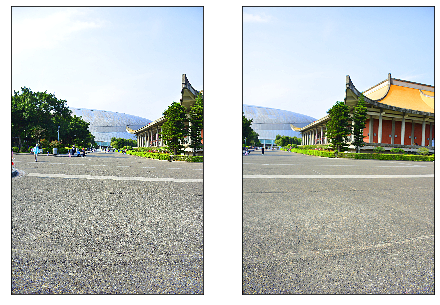

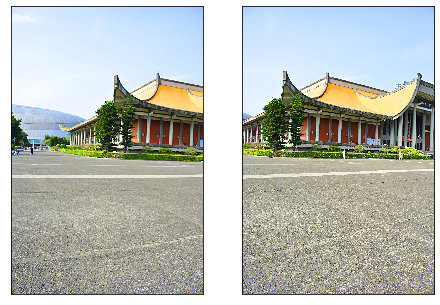

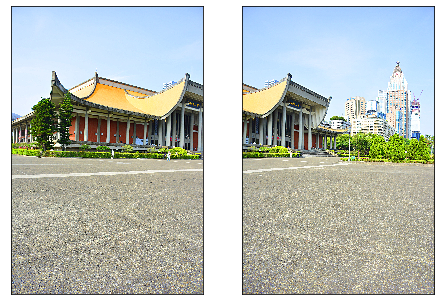

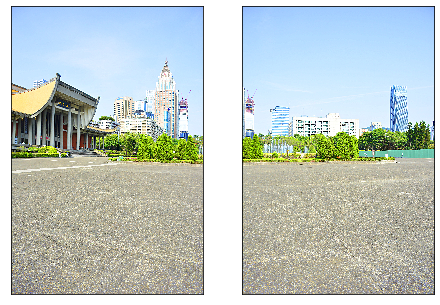

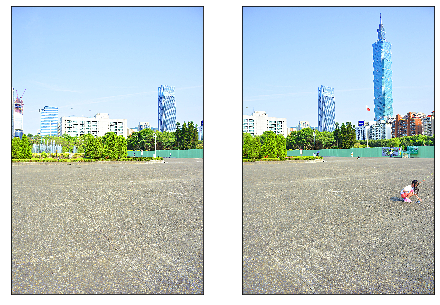

In [233]:
stitching(config['path'])

plot()